In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize
import concurrent.futures
import numba
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)

# Wright-Fisher model 

Single-locus, bi-allelic model with selection, mutation, and drift.

$$
p' = \frac{p (1+s) (1-u) + (1-p) u}{1 + ps} \\
p'' \sim Bin(N, p')/N
$$

In [98]:
def WF(p0, N, s, u, generations, reps=1):
    assert N >= 0
    assert s >= 0
    assert 1 >= u >= 0
    assert generations > 0
    assert reps > 0
    N = int(N)
    generations = int(generations)
    reps = int(reps)
    p = np.empty((generations, reps), dtype=float)
    p[0, :] = p0
    
    for t in range(1, generations):
        p[t, :] = p[t-1, :] * (1 + s) * (1 - u) + (1 - p[t-1, :]) * u
        p[t, :] /= (1 + p[t, :] * s)
        assert (p[t,:] <= 1).all()
        assert (p[t,:] >= 0 ).all()
        if N > 0:
            p[t, :] = np.random.binomial(N, p[t, :]) / N

    return p

In [33]:
p = WF(p0=0, N=1e8, s=0.1, u=1e-8, generations=300, reps=100)

(0, 1)

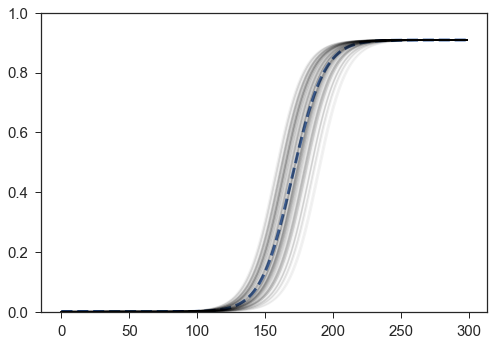

In [34]:
plt.plot(p.mean(axis=1), lw=3, ls='--')
plt.plot(p, color='k', alpha=0.05)
plt.ylim(0, 1)

# Reference experiment

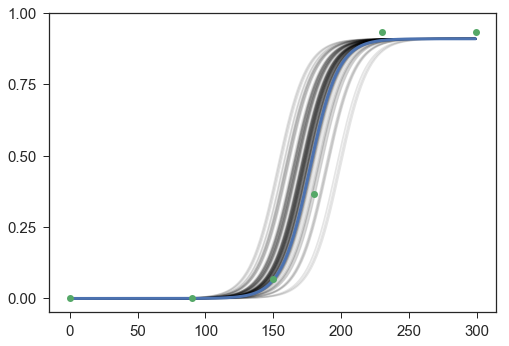

In [260]:
p0=0
N=1e8
s=0.1
u=1e-8

experiment = WF(p0, N, s, u, generations=300, reps=1).squeeze()

sample_times = [0, 90, 150, 180, 230, 299]
sample_size = 30
samples = np.random.binomial(sample_size, experiment[sample_times]) / sample_size

plt.plot(WF(p0, N, s, u, generations=300, reps=100), color='k', alpha=0.1)
plt.plot(experiment, lw=3, label='experiment')
plt.plot(sample_times, samples, 'o', label='samples')
plt.yticks(np.linspace(0, 1, 5));

# Inference of _u_

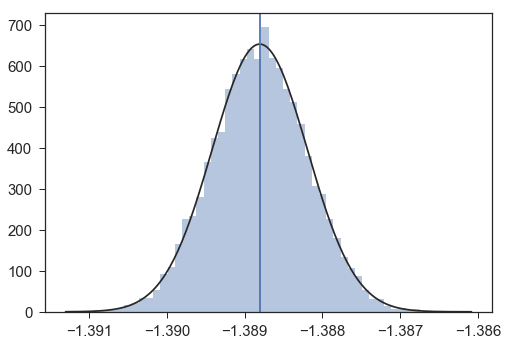

In [261]:
def binom_loglik(obs_freq, model_freq, sample_size):
    return stats.binom(sample_size, model_freq).logpmf(obs_freq * sample_size)

y = WF(samples[-2], N, s, u, sample_times[-1] - sample_times[-2], reps)
L = binom_loglik(samples[-1], y[-1], sample_size)
sns.distplot(L, kde=False, fit=stats.norm)
plt.axvline(L.mean());

In [262]:
def estimate_loglikelihood(sample_times, samples, N, s, u, sample_size, reps, PLOT=False):
    if PLOT:
        fig, axes = plt.subplots(2, len(sample_times)-1, figsize=(20, 6), squeeze=False)
    loglikelihood = 0
    for j, t1, t2, x1, x2, color in zip(range(len(sample_times)-1), sample_times[:-1], sample_times[1:], samples[:-1], samples[1:], sns.color_palette('Set1', 9)):
        y = WF(x1, N, s, u, t2-t1+1, reps)
        if PLOT:
            axes[0, j].plot(np.arange(t1, t2+1), np.median(y, axis=1), alpha=1, ls='-', color=color)
            axes[0, j].plot([t1, t2], [x1, x2],  'o', color=color)
            axes[0, j].set(ylim=(0, 1), xlabel='Generations')

        L = binom_loglik(x2, y[-1], sample_size)
        loglikelihood += L.mean()
        if PLOT:
            sns.distplot(L, kde=False, ax=axes[1, j], hist_kws=dict(alpha=0.2, color=color))
            axes[1, j].axvline(L.mean(), color=color)
            axes[1, j].set(xlabel='Log-Likelihood')
    if PLOT:
        axes[0, 0].set(ylabel='Frequency')
        axes[1, 0].set(ylabel='Frequency')
        fig.tight_layout()
    return loglikelihood

-21.615264500213918

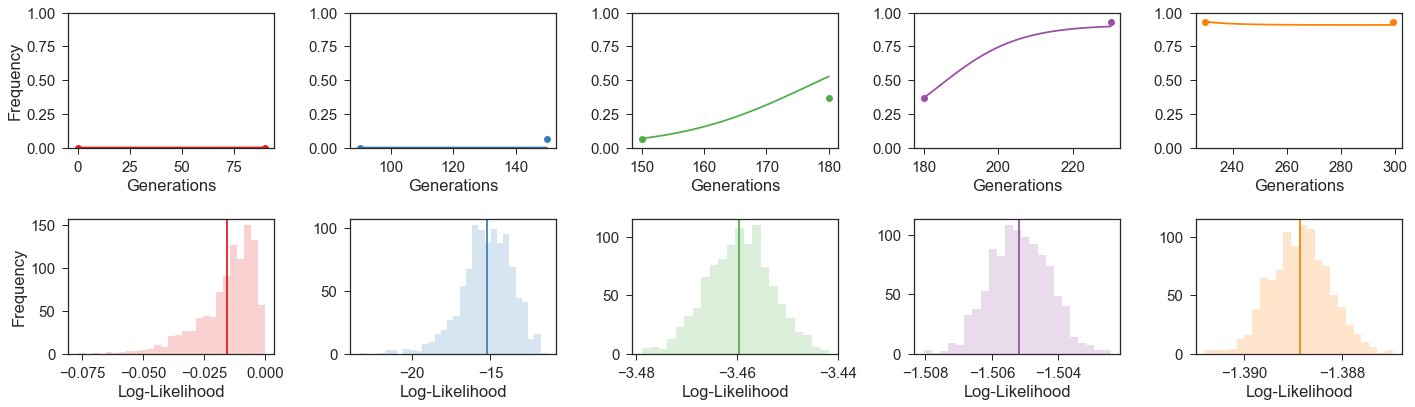

In [263]:
estimate_loglikelihood(sample_times, samples, N, s, u, sample_size, reps=1000, PLOT=True)

-13.510706074354342

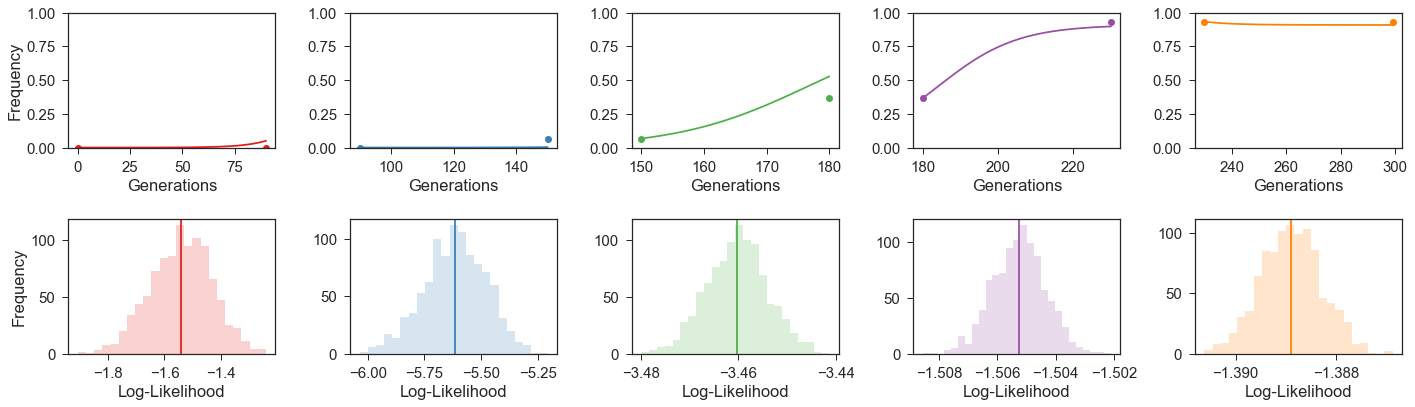

In [264]:
estimate_loglikelihood(sample_times, samples, N, s, u*100, sample_size, reps=1000, PLOT=True)

In [273]:
us = np.logspace(-12, -2, 1000)
def f(u):
    return estimate_loglikelihood(sample_times, samples, N, s, u, sample_size, reps=1000, PLOT=False)
with concurrent.futures.ProcessPoolExecutor() as executor:
    logLs = executor.map(f, us)
logLs = np.array(list(logLs))

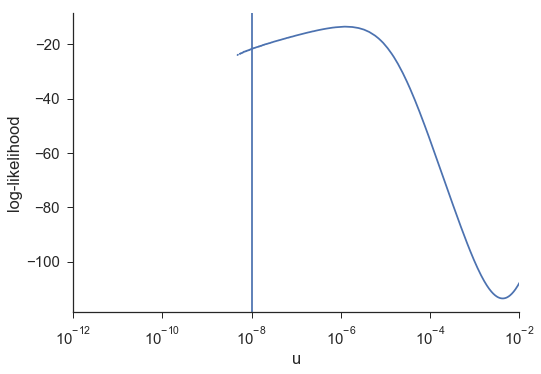

In [274]:
plt.plot(us, logLs)
plt.axvline(u)
plt.xscale('log')
plt.xlim(1e-12, 1e-2)
plt.xlabel('u')
plt.ylabel('log-likelihood')
sns.despine()